In [173]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys

import numpy as np
import pandas as pd
import csv

In [174]:
with open('chembl_dopamin_d2_rp_ki.csv', "r") as f:
    reader = csv.DictReader(f, delimiter=";")
    ligands = [Chem.MolFromSmiles(m["Smiles"]) for m in reader]

supplier = Chem.SDMolSupplier("../data/drugbank.sdf")
drugbank = [m for m in supplier if m!=None]

print(len(ligands))
print(len(drugbank))

RDKit ERROR: [11:20:58] ERROR: Explicit valence for atom # 0 C greater than permitted
RDKit ERROR: [11:35:23] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [11:35:24] ERROR: Could not sanitize molecule ending on line 20009
RDKit WARNING: [11:35:24] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [11:35:24] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit ERROR: [11:35:24] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [11:35:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [11:35:24] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [11:35:24] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [11:35:24] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [11:35:24] ERROR: Could not sanitize molecule ending on line 258130
RDKit ERROR: [11:35:24] ERROR: Explicit v

10473
7113


RDKit ERROR: [11:35:25] ERROR: Explicit valence for atom # 0 Be, 3, is greater than permitted
RDKit ERROR: [11:35:26] Explicit valence for atom # 0 C greater than permitted
RDKit ERROR: [11:35:26] ERROR: Could not sanitize molecule ending on line 1151592


In [175]:
def compareECFPProportions(lig, db):
    np.set_printoptions(suppress=True)
    lig_sum = np.zeros(len(lig[0]))
    db_sum = np.zeros(len(db[0]))
    for l in lig:
        for i,b in enumerate(l.ToBitString()):
            if int(b) == 1:
                lig_sum[i] += 1
    for d in db:
        for i, b in enumerate(d.ToBitString()):
            if int(b) == 1:
                db_sum[i] += 1
    lig_prop = np.divide(lig_sum,len(lig))
    db_prop = np.divide(db_sum, len(db))
    proportions = np.subtract(lig_prop, db_prop)
    proportions_dict = dict(enumerate(proportions))
    proportions_sorted = {k: v for k,v in sorted(proportions_dict.items(), key=lambda x:x[1])}
    return proportions_sorted 

In [176]:
fp_ligands = [Chem.GetMorganFingerprintAsBitVect(l, 2, nBits = 1024) for l in ligands]
fp_drugbank = [Chem.GetMorganFingerprintAsBitVect(d, 2, nBits = 1024) for d in drugbank]
len(fp_ligands), len(fp_drugbank)

(10473, 7113)

In [177]:
proportions = compareECFPProportions(fp_ligands, fp_drugbank)
len(proportions)

1024

In [178]:
first5 = {k: proportions[k] for k in list(proportions)[:5]}
last5 = {k: proportions[k] for k in list(proportions)[-5:]}
print(first5)
print(last5)

{147: -0.26741375051985417, 807: -0.2634642884599361, 1: -0.2296193908354165, 650: -0.16092228563231603, 389: -0.1206609367632211}
{121: 0.48416773980031724, 935: 0.5117840525271891, 926: 0.5169280868162405, 767: 0.5597129257241703, 456: 0.590958582699229}


Co znamená bit 147 (bit výrazně víckrát "zapnutý" v drugbank oproti d2d) a 456 (bit výrazně vícekrát zapnutý v d2d)? Následující funkce vrací substruktury, které se mapují na daný bit. Koukala jsem se na Vaší funkci v notebooku se zadáním a trochu mě mate (zejména proměnná hit_atoms, nikde ve funkci se neaktualizuje na zkoumanou molekulu).

In [195]:
def substruct_on_bit(mol, bit):
    bitinfo = {}
    #vytvoř fingerprint a ulož informace o něm -> {bit:atom,jak široké okolí(poloměr)}
    Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024, bitInfo=bitinfo)
    submols = []
    #pro každý atom a jeho okolí, které se mapuje na tento bit
    for atom, radius in bitinfo.get(bit, []):
        #žádné okolí
        if radius ==0:
            continue
        #najdi co je kolem
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom)
        #a udělej z toho molekulu
        submols.append(Chem.PathToSubmol(mol, env))
    return submols 

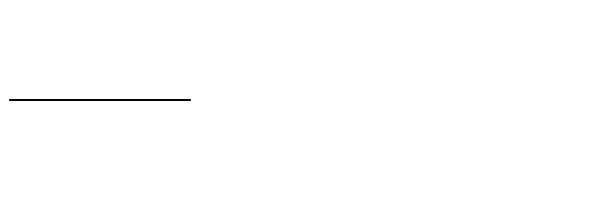

In [196]:
ethanol = Chem.MolFromSmiles("CCO")
Draw.MolsToGridImage(substruct_on_bit(ethanol, 294))

In [197]:
lig_substruct_smiles ={}
for l in ligands:
    for s in substruct_on_bit(l, 456):#substructures_of_bit_ecfp4_1024, pokus
        sub_smiles = Chem.MolToSmiles(s)
        lig_substruct_smiles[sub_smiles] = lig_substruct_smiles.get(sub_smiles, 0) + 1
lig_substruct_smiles

{'CCN': 23655,
 'ccc(c(c)Cl)N(C)C': 55,
 'cccn(c)C': 14,
 'cc(C)c(=O)n(c)C': 1,
 'cC[C@H](C(C)C)N(C)C': 46,
 'CC(=O)O': 5,
 'ccc(C)c(c)Cl': 5,
 'CCn': 72,
 'cC(=O)O': 44,
 'ccc(c(c)C)c(c)o': 1,
 'cc(c)nc(C)s': 5,
 'ccc(C#N)c(c)-c': 3,
 'cC[C@@H](C(C)C)N(C)C': 2,
 'ccc(C(C)=O)c(c)O': 1,
 'cnc(cn)C(N)=O': 1,
 'CC(C)C': 1,
 'cc(-c)cc(n)N': 3,
 'cc(n)n(c([nH])=O)C(C)C': 1,
 'cc(O)cc(c)F': 2,
 'CC[C@@H](C(C)C)C(C)(C)C': 1,
 'cCC(C(C)C)N(C)C': 1,
 'ccc(nc)-c(c)n': 1,
 'cc(c)S(=O)(=O)c(c)n': 2,
 'cnc(c(c)C)N(C)c': 1}

In [198]:
db_substructure_smiles = {}
for d in drugbank:
    for s in substruct_on_bit(d, 456):
        sub_smiles = Chem.MolToSmiles(s)
        db_substructure_smiles[sub_smiles] = db_substructure_smiles.get(sub_smiles, 0) + 1
db_substructure_smiles
#substructures_of_bit_ecfp4_1024, pokus

{'CCN': 1779,
 'cC(=O)O': 319,
 'CC(=O)O': 79,
 'cnc(c(c)C)N(C)c': 1,
 'CCn': 22,
 'cnc(cn)C(N)=O': 1,
 'CC[C@@H](C(C)C)C(C)(C)C': 5,
 'CC(c)C': 3,
 'Cn(nn)c(n)=O': 1,
 'cC[C@H](NC)[C@@H](C)O': 1,
 'C=C(C)C': 2,
 'CC(C)CN(C)C': 7,
 'NC(=O)C[NH3+]': 6,
 'c[nH]c(c(c)C)[C@H](C)N': 1,
 'CC(=N)/C(C)=C(/C)N': 1,
 'cc(c)S(=O)(=O)O': 16,
 'CC[C@@H](CS)C(N)=O': 1,
 'cnc(co)C(C)C': 1,
 'cccn(c)C': 1,
 'CC(=O)S': 4,
 'CC(=O)C=O': 1,
 'CNC(=O)N(C)N': 1,
 'ccc(C)c(c)Cl': 2,
 'CN=CO': 1,
 'C[C@@H](N)CCS': 1,
 'cc(C)c(C)c(c)N': 1,
 'CCN(C(C)=O)N(C)C': 1,
 'CNCCN': 3,
 'cc(c)[C@H](CC)OP': 1,
 'c/N=C(\\N)N(c)C': 1,
 'CC[C@@H](C)N': 1,
 'cc(c)C(C(N)=O)(C(N)=O)N(C)C': 1,
 'cc(c)[C@H](NS)C(N)=O': 1,
 'ccc(-c([nH])n)c(c)N': 1,
 'CC(C)O[P@H](C)=O': 2,
 'cc(C)c(c(c)S)c(c)c': 1,
 'cc(n)[C@@](C)(NC)C(C)C': 1,
 'C[C@@H](O)CC(=O)O': 1,
 'cc(-c)cc(n)N': 2,
 'cC[C@H](C(C)C)N(C)C': 1}

Nejčastější stuktura bitu 456 v datasetu d2d je CCN (23655) i mezi látkami drugbanku je nejčastější, ale zdaleka není tak zastoupená jako v d2d (1779). V drugbank ji má průměrně (+/-) každá 3 molekula zatímco v mém datasetu ji má každá molekula průměrně (+/-) 2x. Ostatní stuktury co se do tohoto bitu mapují jsou málo zastoupené, až na ccc(c(c)Cl)N(C)C, cC[C@H](C(C)C)N(C)C u d2d a cC(=O)O, CC(=O)O u db.

In [199]:
lig_substruct_smiles ={}
for l in ligands:
    for s in substruct_on_bit(l, 147):#substructures_of_bit_ecfp4_1024, pokus
        sub_smiles = Chem.MolToSmiles(s)
        lig_substruct_smiles[sub_smiles] = lig_substruct_smiles.get(sub_smiles, 0) + 1
lig_substruct_smiles

{'cc(C)oc(c)c': 48,
 'COC': 102,
 'CC(=O)O': 23,
 'ccc(C)c(c)-c': 10,
 'cC(C)C': 1,
 'ccc(OC)c(c)N': 11,
 'ccc(C)c(c)C': 2,
 'CC(c)C': 8,
 'CCN[C@@H](C)C': 1,
 'cC(C)(C)CCN': 3,
 'CC(C)(c)CCN': 4,
 'cncn(c)n': 1,
 'CC(C)(C)O': 2,
 'COC(=O)N(C)N': 1}

In [200]:
db_substructure_smiles = {}
for d in drugbank:
    for s in substruct_on_bit(d, 147):
        sub_smiles = Chem.MolToSmiles(s)
        db_substructure_smiles[sub_smiles] = db_substructure_smiles.get(sub_smiles, 0) + 1
db_substructure_smiles

{'COC': 338,
 'CC(=O)O': 86,
 'CC(C)c': 20,
 'cc(s)C(=O)NC': 4,
 'CC(C)(c)CCN': 12,
 'CC(c)(C)CCN': 3,
 'COC(=O)N(C)N': 1,
 'O=P(O)(O)F': 1,
 'C[C@H](N)SC(C)(C)C': 4,
 'cc(C)oc(c)c': 6,
 'cc(c)C(N(C)C)S(C)(=O)=O': 1,
 'cC(C)(C)CCN': 1,
 'C=CC(C)N(C)C': 1,
 'CC(c)c': 1,
 'cc(n)C(=O)N(C)C': 1,
 'CP(=O)([O-])[O-]': 5,
 'C=[N+](C)C': 1,
 'cn(n)C(C)(C)C': 6,
 'CNO': 12,
 'NC=[SH]': 1,
 'cnc(nc)NC': 1,
 'O=P(O)(O)OS(=O)(=O)O': 2,
 'cC(P)P(=O)(O)O': 2,
 'C[C@@H](N)SC(C)(C)C': 2,
 'cc(-c)nc(C)s': 1,
 'C=CC': 4,
 'CC(C)S[C@H](C)N': 1,
 'cc(c)NN=N': 1,
 'ccc(C(C)=O)c(c)C': 1,
 'cC(C)C': 3,
 'cc(c)[nH]c(C)n': 2,
 'CC(=O)C(N)=O': 2,
 'CC(C)(C)O': 2,
 'cc([nH])ncn': 19,
 'ccc(C)c(c)C': 4,
 'cn(c)C[C@@H](C)N': 2,
 'cncn(c)n': 1,
 'ccc(C)c(c)-c': 4,
 'cC(c)c': 1,
 'cc(n)CC(c)C': 1,
 'cnc(CC)c(c)C': 1,
 'COC(C)=C(C)C': 1,
 'CC(c)C': 2,
 'CC(c)(c)CCN': 2}

Nejhojněji zastoupená struktura mapující se na bit 147 je v db COC (308) stejně jako v d2d (102).